# Gun Violence — National vs Hawaii Trends (2014–2024)

This notebook merges incident and participant data, computes national statistics, adds state population estimates, and compares Hawaii against national trends.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('/Users/johnnybae/Documents/Academia/Chaminade/DS495 - Research')
incidents = pd.read_csv(DATA_DIR / 'Incidents/incidents_all_years.csv.gz',
                  na_values=['N/A'], low_memory=False)
participants = pd.read_csv(DATA_DIR / 'Participants/participants_all_years.csv.gz',
                    na_values=['N/A'], low_memory=False)

print(f'Incidents: {len(incidents):,} rows | Participants: {len(participants):,} rows')

Incidents: 449,386 rows | Participants: 803,861 rows


In [2]:
# keep only what we need from participants
need = [c for c in ['ID', 'State', 'Date'] if c in participants.columns]
part_tag = participants[need].copy()

# robust date parsing: try a few formats we expect
# example: '31-Dec-14' -> '%d-%b-%y'
dt = pd.to_datetime(part_tag['Date'], errors='coerce')
formats = ['%d-%b-%y', '%Y-%m-%d', '%m/%d/%Y', '%m/%d/%y']
for fmt in formats:
    mask = dt.isna()
    if not mask.any():
        break
    dt.loc[mask] = pd.to_datetime(part_tag.loc[mask, 'Date'], format=fmt, errors='coerce')

part_tag['Year'] = dt.dt.year

# collapse to a single row per incident ID
def first_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

agg_spec = {'State': first_mode}
if 'Year' in part_tag.columns:
    agg_spec['Year'] = 'max'

id_map = part_tag.groupby('ID', as_index=False).agg(agg_spec)

# make incident numeric columns numeric
for c in ['Vic-Killed','Vic-Injured','Sus-Killed','Sus-Injured','Sus-Unharmed','Sus-Arrested']:
    if c in incidents.columns:
        incidents[c] = pd.to_numeric(incidents[c], errors='coerce')

# lightweight merge (incident-level ⟵ id_map)
incidents_enriched = incidents.merge(id_map, on='ID', how='left')

# sanity checks
print("Incidents rows:", len(incidents_enriched))
print("IDs with no State after merge:", incidents_enriched['State'].isna().sum())
print(incidents_enriched[['ID','State','Year']].head())

/var/folders/vg/b0s2p58n6p14svh9j4syj9r00000gn/T/ipykernel_26480/2067171248.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(part_tag['Date'], errors='coerce')


Incidents rows: 449386
IDs with no State after merge: 20708
          ID        State    Year
0  3040722.0   California  2014.0
1  3040717.0   California  2014.0
2   291511.0     Virginia  2014.0
3   278757.0  Mississippi  2014.0
4   277950.0     Virginia  2014.0


National aggregates by year

In [3]:
yearly = (incidents_enriched.groupby('Year', dropna=True)
          .agg(incidents=('ID','nunique'),
               victims_killed=('Vic-Killed','sum'),
               victims_injured=('Vic-Injured','sum'))
          .reset_index()
          .sort_values('Year'))

print("Yearly (national):")
print(yearly.head(11))

Yearly (national):
      Year  incidents  victims_killed  victims_injured
0   2014.0      27221         10757.0          20759.0
1   2015.0      32129         11699.0          24546.0
2   2016.0      36365         13078.0          28112.0
3   2017.0      37011         13397.0          28561.0
4   2018.0      34665         12522.0          26083.0
5   2019.0      36447         13126.0          28343.0
6   2020.0      47062         17363.0          37638.0
7   2021.0      48894         18773.0          38747.0
8   2022.0      46661         17809.0          36683.0
9   2023.0      43813         16391.0          34635.0
10  2024.0      38410         14180.0          29923.0


State-year aggregates

In [4]:
state_year = (incidents_enriched.groupby(['State','Year'], dropna=True)
              .agg(incidents=('ID','nunique'),
                   victims_killed=('Vic-Killed','sum'),
                   victims_injured=('Vic-Injured','sum'))
                   .reset_index())

print("\nState-Year sample:")
print(state_year.head())


State-Year sample:
     State    Year  incidents  victims_killed  victims_injured
0  Alabama  2014.0        723           266.0            498.0
1  Alabama  2015.0        775           336.0            514.0
2  Alabama  2016.0       1001           426.0            709.0
3  Alabama  2017.0       1130           465.0            787.0
4  Alabama  2018.0        985           406.0            710.0


In [9]:
top_states = (
    state_year.groupby('State')['incidents']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

print("Top 5 states with highest incidents:", top_states)

Top 5 states with highest incidents: ['Illinois', 'California', 'Texas', 'Pennsylvania', 'Florida']


Hawaii Vs National

In [5]:
hawaii_yearly = (incidents_enriched[incidents_enriched['State']=='Hawaii']
                 .groupby('Year', dropna=True)
                 .agg(incidents=('ID','nunique'),
                      victims_killed=('Vic-Killed','sum'),
                      victims_injured=('Vic-Injured','sum'))
                 .reset_index()
                 .sort_values('Year'))
hawaii_yearly

,Year,incidents,victims_killed,victims_injured
0,2014.0,20,6.0,11.0
1,2015.0,28,8.0,23.0
2,2016.0,41,24.0,13.0
3,2017.0,22,5.0,18.0
4,2018.0,44,15.0,21.0
5,2019.0,39,12.0,20.0
6,2020.0,37,15.0,23.0
7,2021.0,45,14.0,28.0
8,2022.0,41,15.0,27.0
9,2023.0,51,19.0,36.0


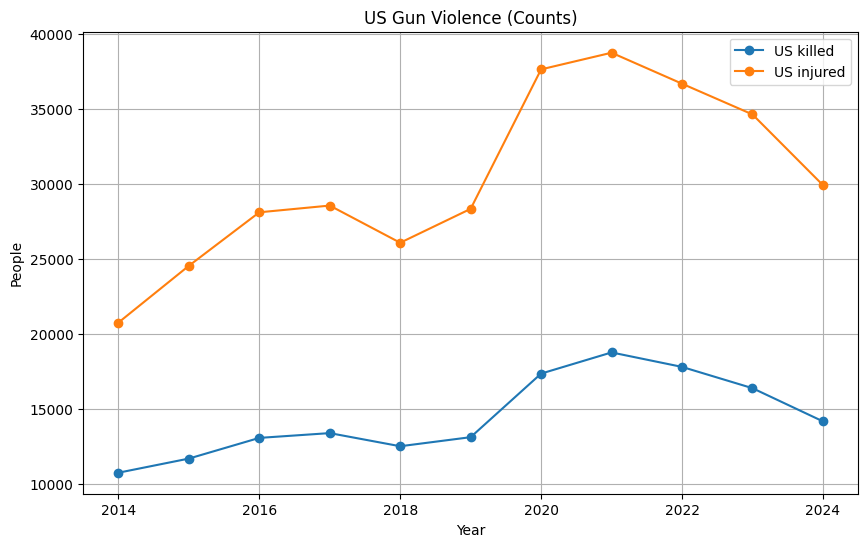

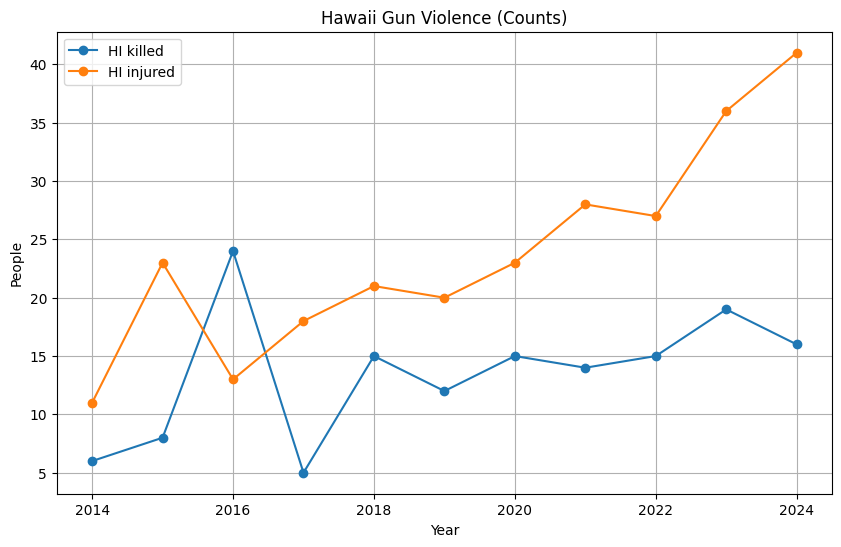

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(yearly['Year'], yearly['victims_killed'], marker='o', label='US killed')
plt.plot(yearly['Year'], yearly['victims_injured'], marker='o', label='US injured')
plt.title('US Gun Violence (Counts)'); plt.xlabel('Year'); plt.ylabel('People'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
plt.plot(hawaii_yearly['Year'], hawaii_yearly['victims_killed'], marker='o', label='HI killed')
plt.plot(hawaii_yearly['Year'], hawaii_yearly['victims_injured'], marker='o', label='HI injured')
plt.title('Hawaii Gun Violence (Counts)'); plt.xlabel('Year'); plt.ylabel('People'); plt.legend(); plt.grid(True); plt.show()

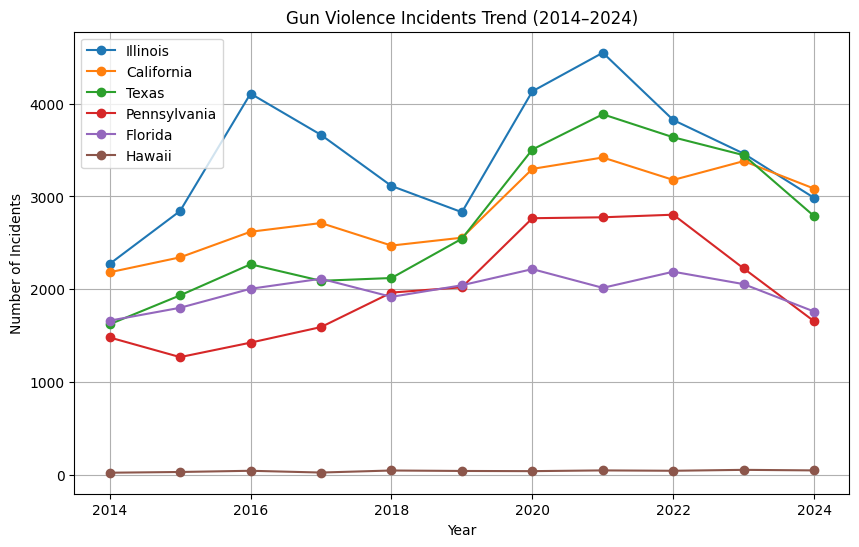

In [10]:
compare_states = top_states + ['Hawaii']
subset = state_year[state_year['State'].isin(compare_states)]

plt.figure(figsize=(10,6))
for st in compare_states:
     st_data = subset[subset['State'] == st]
     plt.plot(st_data['Year'], st_data['incidents'], marker='o', label=st)

plt.title('Gun Violence Incidents Trend (2014–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()
